In [1]:
# Cell 1 - Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import early_stopping, log_evaluation
import time


ModuleNotFoundError: No module named 'seaborn'

In [ ]:
# Cell 2 - Load data
file_path = "path_from_papermill"
realtordata = pd.read_csv('CSVS/realtor-data.csv')
realtordata.columns = realtordata.columns.str.strip().str.lower()

In [ ]:
# Load your dataset

# Clean column names (in case they're inconsistent)
realtordata.columns = realtordata.columns.str.strip().str.lower()

# Drop missing prices (to avoid errors)
realtordata = realtordata.dropna(subset=["price"])

# Filter for houses with price > 300K
over_300k = realtordata[realtordata["price"] > 1100000]

# Count how many
count = len(over_300k)

# Print result
print(f"🏡 Houses over $300,000: {count}")

🏡 Houses over $300,000: 173272


In [ ]:
# 📊 Summary statistics
print("📌 Price Summary:")
print(realtordata['price'].describe())

# 💰 Price range
min_price = realtordata['price'].min()
max_price = realtordata['price'].max()
median_price = realtordata['price'].median()
mean_price = realtordata['price'].mean()

print(f"\n🔻 Min price: ${min_price:,.0f}")
print(f"🔺 Max price: ${max_price:,.0f}")
print(f"⚖️ Median price: ${median_price:,.0f}")
print(f"🧮 Mean price: ${mean_price:,.0f}")



📌 Price Summary:
count    2.224841e+06
mean     5.241955e+05
std      2.138893e+06
min      0.000000e+00
25%      1.650000e+05
50%      3.250000e+05
75%      5.500000e+05
max      2.147484e+09
Name: price, dtype: float64

🔻 Min price: $0
🔺 Max price: $2,147,483,600
⚖️ Median price: $325,000
🧮 Mean price: $524,196


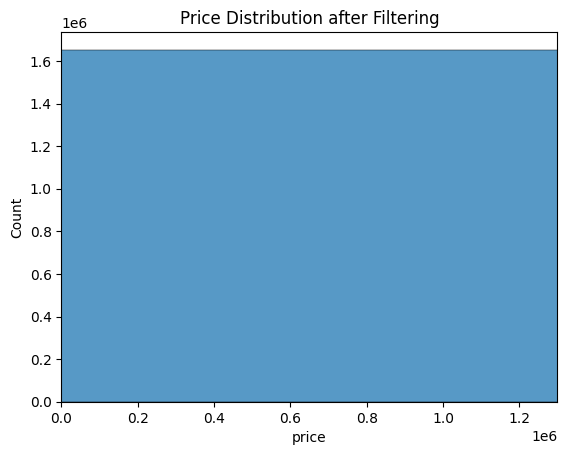

🧹 After filtering, remaining rows: 1395754
🔍 Dropped rows: 261101


In [ ]:
# Cell 3 - Drop rows with missing essential values
realtordata = realtordata.dropna(subset=['price', 'house_size', 'zip_code'])  # ✅ Already present

import seaborn as sns
sns.histplot(realtordata['price'], bins=100)
plt.xlim(0, 1300000)
plt.title("Price Distribution after Filtering")
plt.show()

# Cell 3.5 - Log-transform skewed numeric features
realtordata['house_size'] = np.log1p(realtordata['house_size'])
realtordata['acre_lot'] = np.log1p(realtordata['acre_lot'])
# ✅ Cell 3.6 - Filter price range to $50K–$650K
initial_count = len(realtordata)
realtordata = realtordata[(realtordata['price'] >= 50000) & (realtordata['price'] <= 800000)].copy()

print(f"🧹 After filtering, remaining rows: {len(realtordata)}")
print(f"🔍 Dropped rows: {initial_count - len(realtordata)}")


📌 Price Summary:
count    1.395754e+06
mean     3.611655e+05
std      1.817274e+05
min      5.000000e+04
25%      2.200000e+05
50%      3.360000e+05
75%      4.800000e+05
max      8.000000e+05
Name: price, dtype: float64

🔻 Min price: $50,000
🔺 Max price: $800,000
⚖️ Median price: $336,000
🧮 Mean price: $361,165


C:\Users\Mudit Dua\AppData\Local\Temp\ipykernel_65860\3971558677.py:27: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mudit Dua\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


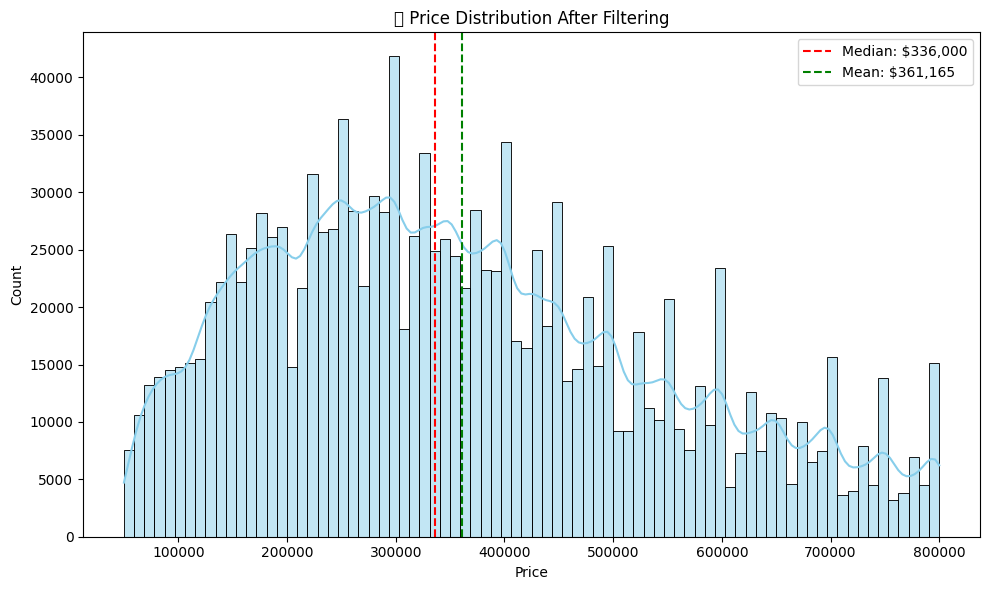

In [ ]:
# 📊 Summary statistics
print("📌 Price Summary:")
print(realtordata['price'].describe())

# 💰 Price range
min_price = realtordata['price'].min()
max_price = realtordata['price'].max()
median_price = realtordata['price'].median()
mean_price = realtordata['price'].mean()

print(f"\n🔻 Min price: ${min_price:,.0f}")
print(f"🔺 Max price: ${max_price:,.0f}")
print(f"⚖️ Median price: ${median_price:,.0f}")
print(f"🧮 Mean price: ${mean_price:,.0f}")

# 📈 Distribution plot


plt.figure(figsize=(10, 6))
sns.histplot(realtordata['price'], bins=80, kde=True, color="skyblue")
plt.axvline(median_price, color='red', linestyle='--', label=f"Median: ${median_price:,.0f}")
plt.axvline(mean_price, color='green', linestyle='--', label=f"Mean: ${mean_price:,.0f}")
plt.title("🏠 Price Distribution After Filtering")
plt.xlabel("Price")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Cell 4 - Fill missing values
# Fill missing numeric columns with their median
for col in ['bed', 'bath', 'acre_lot']:
    if col in realtordata.columns:
        realtordata[col] = realtordata[col].fillna(realtordata[col].median())

# Fill missing 'city' and 'state' with mode
for col in ['city', 'state']:
    if col in realtordata.columns:
        realtordata[col] = realtordata[col].fillna(realtordata[col].mode()[0])
# Ordinal encode 'city' with unknown handling
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
realtordata['city'] = oe.fit_transform(realtordata[['city']])
joblib.dump(oe, "ordinal_encoder_city.pkl")



['ordinal_encoder_city.pkl']

In [ ]:
# Cell 5 - Drop unnecessary columns (✅ already listed, reaffirming logic)
columns_to_drop = ['street', 'status', 'brokered_by', 'prev_sold_date']
realtordata = realtordata.drop(columns=[col for col in columns_to_drop if col in realtordata.columns])

In [ ]:
# Cell 6 - Save a version with 'state' for dropdown (web display)
webdata = realtordata.copy()
webdata.to_csv("web_data.csv", index=False)

In [ ]:
# Cell 7 - Prepare data for ML model

ml_data = realtordata.copy()

# Fit and transform 'city' using OrdinalEncoder
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
ml_data['city'] = ordinal_encoder.fit_transform(ml_data[['city']])
ml_data['city'] = ml_data['city'].astype('category')  # Tell LightGBM this is categorical

# Save encoder for use in clean.ipynb later
joblib.dump(ordinal_encoder, "ordinal_encoder_city.pkl")

# One-hot encode 'state' only
ml_data = pd.get_dummies(ml_data, columns=['state'], drop_first=True)

# Also save a cleaned version for debugging/testing (optional)
realtordata.to_csv("cleaned_data.csv", index=False)
print("📄 cleaned_data.csv saved.")

📄 cleaned_data.csv saved.


In [ ]:
# ✅ Cell 8 - Train/test split and model training: Quantile + Mean + Final Blend



# 1. Data split
X = ml_data.drop(columns=['price'])
y = ml_data['price']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=1
)

y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)

sample_weights = 1 / (y_train ** 0.05)

# 2. ✅ Quantile Regression Model (underpredicts)
quantile_model = LGBMRegressor(
    objective='quantile',
    alpha=0.35,
    n_estimators=4000,
    max_depth=20,
    learning_rate=0.02,
    random_state=1,
    n_jobs=-1
)

quantile_model.fit(
    X_train, y_train_log,
    eval_set=[(X_valid, y_valid_log)],
    callbacks=[
        early_stopping(stopping_rounds=150),
        log_evaluation(period=100)
    ],
    sample_weight=sample_weights,
    categorical_feature=['city'],
)

# 3. ✅ Mean Regression Model (standard)
mean_model = LGBMRegressor(
    objective='regression',
    n_estimators=4000,
    max_depth=20,
    learning_rate=0.02,
    random_state=1,
    n_jobs=-1
)

mean_model.fit(
    X_train, y_train_log,
    eval_set=[(X_valid, y_valid_log)],
    callbacks=[
        early_stopping(stopping_rounds=150),
        log_evaluation(period=100)
    ],
    sample_weight=sample_weights,
    categorical_feature=['city'],
)

# 4. Predict both
quantile_preds = np.expm1(quantile_model.predict(X_valid))
mean_preds = np.expm1(mean_model.predict(X_valid))

# 5. ✅ Final blended prediction (tweak ratio as needed)
final_pred = 0.90 * quantile_preds + 0.10 * mean_preds

# 6. Evaluate final prediction
mae = mean_absolute_error(y_valid, final_pred)
r2 = r2_score(y_valid, final_pred)

print(f"\n✅ Blended Model (90% Quantile + 10% Mean)")
print(f"📉 MAE: ${mae:,.2f}")
print(f"📈 R² Score (Test): {r2:.4f}")

# 7. Save models
joblib.dump(quantile_model, "realtor_quantile_model.pkl")
joblib.dump(mean_model, "realtor_mean_model.pkl")
joblib.dump(X_train.columns.tolist(), "trained_columns.pkl")

print("✅ Quantile and Mean models saved.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7771
[LightGBM] [Info] Number of data points in the train set: 1116603, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 12.468441
Training until validation scores don't improve for 150 rounds
[100]	valid_0's quantile: 0.139657
[200]	valid_0's quantile: 0.124804
[300]	valid_0's quantile: 0.117829
[400]	valid_0's quantile: 0.113969
[500]	valid_0's quantile: 0.111325
[600]	valid_0's quantile: 0

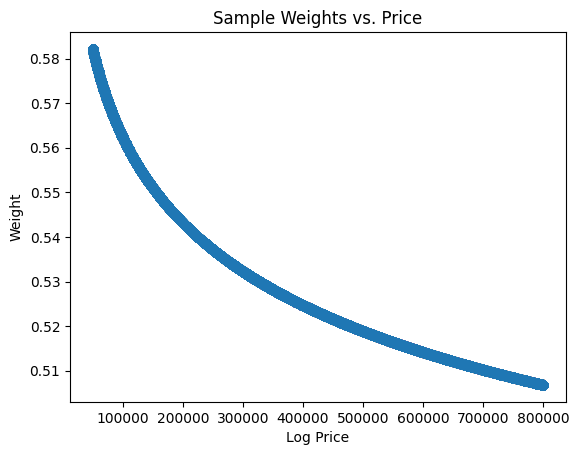

In [ ]:
plt.scatter(y_train, sample_weights, alpha=0.3)
plt.title("Sample Weights vs. Price")
plt.xlabel("Log Price")
plt.ylabel("Weight")
plt.show()

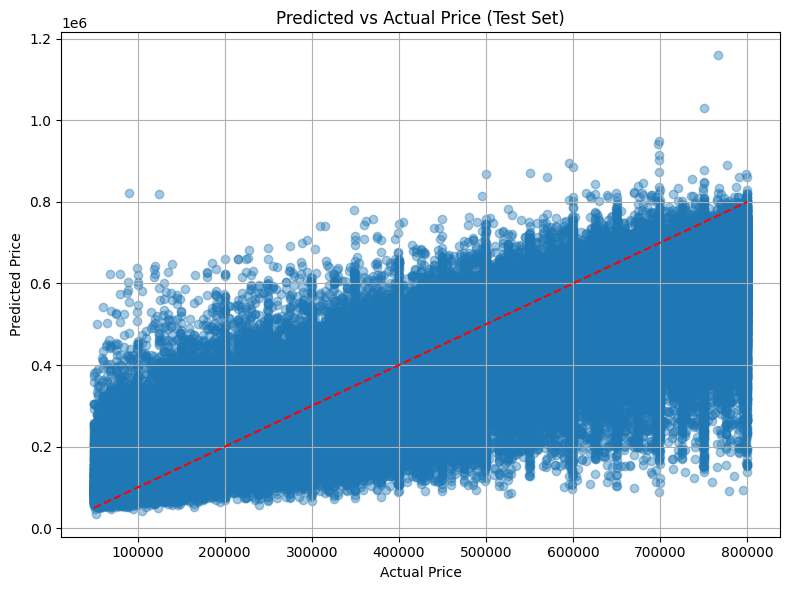

In [ ]:


# Plot actual vs predicted prices
plt.figure(figsize=(8,6))
plt.scatter(y_valid, final_pred, alpha=0.4)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Price (Test Set)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print(realtordata.columns)

Index(['price', 'bed', 'bath', 'acre_lot', 'city', 'state', 'zip_code',
       'house_size'],
      dtype='object')


In [ ]:
# Cell 9 - Predict on same cleaned data and save

user_data = pd.read_csv("cleaned_data.csv")

if 'price' in user_data.columns:
    user_data = user_data.drop(columns=['price'])

# Label encode 'city' the same way (fit a new encoder or save it during training)
user_data['city'] = user_data['city'].fillna(user_data['city'].mode()[0])
ordinal_encoder = joblib.load("ordinal_encoder_city.pkl")
user_data['city'] = ordinal_encoder.transform(user_data[['city']])
user_data['city'] = user_data['city'].astype('category')

# One-hot encode 'state' only
user_data = pd.get_dummies(user_data, columns=['state'], drop_first=True)

# Align with training columns
trained_cols = joblib.load("trained_columns.pkl")
for col in trained_cols:
    if col not in user_data.columns:
        user_data[col] = 0
user_data = user_data[trained_cols]

# Predict
user_preds_log = model.predict(user_data)
user_preds = np.expm1(user_preds_log)

# Save output
user_data_with_preds = user_data.copy()
user_data_with_preds['predicted_price'] = user_preds




NameError: name 'model' is not defined

In [ ]:
output_path = f"uploads/predicted_{int(time.time())}.csv"
user_data_with_preds.to_csv(output_path, index=False)
print(f"✅ Predictions saved to {output_path}")

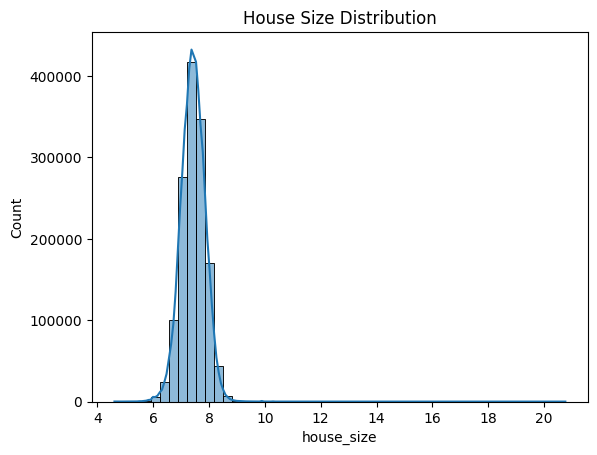

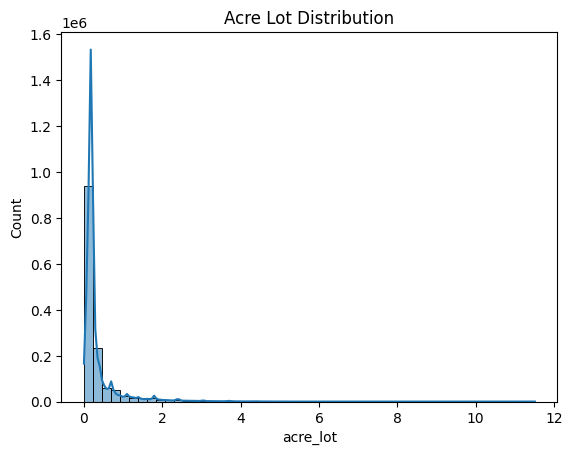

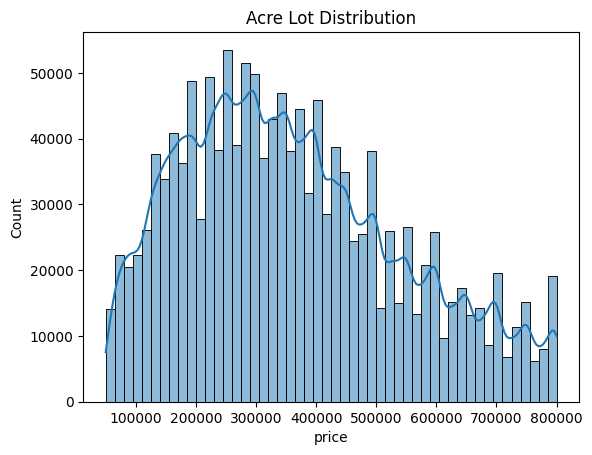

In [ ]:



sns.histplot(realtordata['house_size'], bins=50, kde=True)
plt.title("House Size Distribution")
plt.show()

sns.histplot(realtordata['acre_lot'], bins=50, kde=True)
plt.title("Acre Lot Distribution")
plt.show()

sns.histplot(realtordata['price'], bins=50, kde=True)
plt.title("Acre Lot Distribution")
plt.show()



Text(0.5, 1.0, 'Log-Transformed Price Distribution')

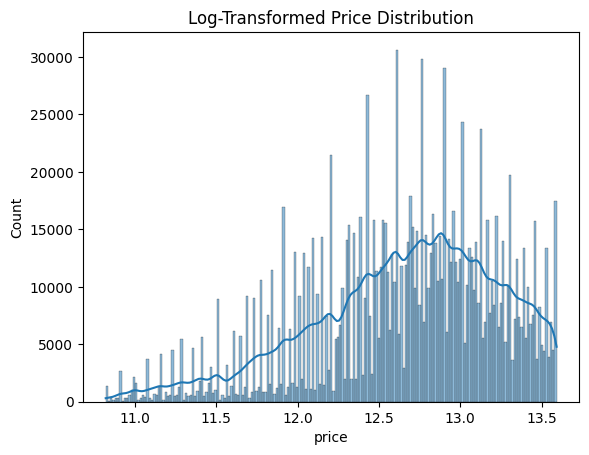

In [ ]:
sns.histplot(np.log1p(realtordata['price']), kde=True)
plt.title("Log-Transformed Price Distribution")
